In [10]:
import networkx as nx

import matplotlib.pyplot as plt
import random
import json
import community as community_louvain

import numpy as np

import numpy as np
from scipy.sparse import csr_matrix

import infomap

In [2]:

def read_directed_graph(file_path, skip_lines):
    G = nx.DiGraph()  # Initialize an empty directed graph
    with open(file_path, 'r') as file:
        for _ in range(skip_lines):
            next(file)  # Skip the initial descriptive lines
        for line in file:
            parts = line.strip().split()
            if len(parts) == 2:  # Only consider lines with exactly two node identifiers
                u, v = parts
                G.add_edge(u, v)
    
    return G


path = '/Users/qing/Desktop/24s1/comp8880/project/code/data/soc/soc-twitter-follows-mun.edges'
G = read_directed_graph(path,0)


In [3]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

num_nodes, num_edges

(465017, 834798)

In [6]:


def leader_rank(G2, damping=0.85, tol=1e-6, max_iter=100):
    # Add the ground node connected to all other nodes
    ground_node = 'ground'
    G = G2.copy()
    G.add_node(ground_node)
    for node in G2.nodes():  # Connect the ground node to all other nodes
        G.add_edge(ground_node, node)
        G.add_edge(node, ground_node)  # Assuming undirected graph, add both directions

    # Create a mapping from node to index
    node_list = list(G.nodes())
    node_index = {node: i for i, node in enumerate(node_list)}
    n = len(node_list)
    
    # Initialize scores to 1 for all nodes
    scores = np.ones(n)
    
    # Create adjacency matrix
    row = []
    col = []
    data = []
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        if neighbors:
            degree = len(neighbors)
            for neighbor in neighbors:
                row.append(node_index[neighbor])
                col.append(node_index[node])
                data.append(1.0 / degree)
    
    adjacency_matrix = csr_matrix((data, (row, col)), shape=(n, n))
    
    # Power iteration: iterate until convergence
    for _ in range(max_iter):
        new_scores = adjacency_matrix.dot(scores)
        if np.linalg.norm(new_scores - scores, 1) < tol:
            break
        scores = new_scores
    
    # Remove the ground node score and normalize the scores
    scores = np.delete(scores, node_index[ground_node])
    total_score = np.sum(scores)
    scores /= total_score
    
    # Create the final scores dictionary
    final_scores = {node_list[i]: scores[i] for i in range(n) if node_list[i] != ground_node}
    
    return final_scores


def calculate_h_index(G):
    h_index = {}
    for node in G.nodes():
        degrees = [G.degree(neighbor) for neighbor in G.neighbors(node)]
        degrees.sort(reverse=True)
        h = 0
        for i, degree in enumerate(degrees):
            if degree >= i + 1:
                h = i + 1
            else:
                break
        h_index[node] = h
    return h_index


In [8]:
degree_centrality = nx.degree_centrality(G)
pagerank = nx.pagerank(G, alpha=0.85, personalization=None)
leaderRank = leader_rank(G)
hIndex = calculate_h_index(G)
kShell = nx.core_number(G)


In [9]:
sorted_centrality = sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True)
sorted_pagerank =  sorted(pagerank.items(), key=lambda item: item[1], reverse=True)
sorted_leaderRank =  sorted(leaderRank.items(), key=lambda item: item[1], reverse=True)
sorted_hIndex =  sorted(hIndex.items(), key=lambda item: item[1], reverse=True)
sorted_kShell=  sorted(kShell.items(), key=lambda item: item[1], reverse=True)



In [13]:
# 创建节点映射，将节点字符串映射为整数，同时创建反向映射
node_map = {node: i for i, node in enumerate(G.nodes())}
reverse_node_map = {i: node for node, i in node_map.items()}  # 反向映射

# 初始化 Infomap
im = infomap.Infomap()

# 将网络数据添加到 Infomap 对象，确保节点ID是整数
for edge in G.edges():
    source, target = edge
    im.add_link(node_map[source], node_map[target])

# 运行 Infomap 算法
im.run()


  Infomap v2.7.1 starts at 2024-05-18 14:56:27
  -> Input network: 
  -> No file output!
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'... 
  -> Using undirected links.
  => Sum node flow: 1, sum link flow: 1
Build internal network with 465017 nodes and 834798 links...
  -> One-level codelength: 15.4855172

Trial 1/1 starting at 2024-05-18 14:56:28
Two-level compression: 33% 0.49% 0.00238975026% 0.0292713174% 
Partitioned to codelength 4.2884848 + 5.97550254 = 10.26398734 in 2179 (2174 non-trivial) modules.
Super-level compression: 0.45026712% to codelength 10.21777198 in 52 top modules.

Recursive sub-structure compression: 27.4963772% 0.0292279525% 0% 

In [14]:

# 提取社区分区结果，直接使用反向映射
partition_infomap = {}
for node in im.tree:
    if node.is_leaf:
        original_node = reverse_node_map[node.node_id]  # 直接使用反向映射查找原始节点标识符
        partition_infomap[original_node] = node.module_id

In [15]:
def community_aware_ranking_Baseline(G, partition, node_centrality, budget=None):
    # Organize nodes by community and sort them within each community based on their centrality
    community_nodes = {}
    for node, comm in partition.items():
        if comm not in community_nodes:
            community_nodes[comm] = []
        community_nodes[comm].append(node)

    for comm in community_nodes:
        community_nodes[comm].sort(key=lambda x: node_centrality[x], reverse=True)

    # Select nodes from communities ensuring distribution across communities
    ranked_nodes = []
    if budget is None:
        budget = len(G)
    
    while budget > 0 and any(community_nodes.values()):
        for comm in sorted(community_nodes, key=lambda x: len(community_nodes[x]), reverse=True):
            if community_nodes[comm]:
                ranked_nodes.append(community_nodes[comm].pop(0))
                budget -= 1
                if budget == 0:
                    break
    
    return ranked_nodes

In [38]:
def community_aware_ranking_ours_v5(G, partition, incommunity, communityImportance, total_budget, distance_threshold):
    """
    对社交网络进行资源分配和节点选择，结合社区划分、节点度中心性、k-shell得分和距离阈值。
    使用线性归一化来代替Softmax进行预算分配。

    参数:
    G: NetworkX图对象，表示社交网络。
    partition: 字典，节点到社区ID的映射。
    incommunity: 字典，节点的xxxxx得分用作社区内排名
    communityImportance: 字典，节点的xxxx得分。用作社区安权重
    total_budget: 整个网络的总预算，表示可以选择的节点总数。
    alpha: k-shell得分的权重。
    beta: 社区大小得分的权重。
    distance_threshold: 最短路径距离阈值，用于确定节点间的紧密程度。

    返回:
    selected_nodes: 被选择的节点集合。
    """

    communities = {}
    for node, comm_id in partition.items():
        if comm_id not in communities:
            communities[comm_id] = []
        communities[comm_id].append(node)

    community_scores = {}
    for comm_id, nodes in communities.items():
        core_score = np.mean([communityImportance[node] for node in nodes])  # 计算该社区的平均k-shell得分
        size_score = len(nodes)  # 获取社区的大小
        community_scores[comm_id] = size_score * (core_score*1.5)
    #print("Community Scores:", community_scores)

    # 使用线性归一化来分配预算
    total_score = sum(community_scores.values())
    community_budgets = {comm: int((score / total_score) * total_budget) for comm, score in community_scores.items()}

   # print(community_budgets)
    # 选择节点，考虑节点间的距离阈值
    selected_nodes = set()
    for comm_id in communities:
        community_nodes = communities[comm_id]
        budget = community_budgets[comm_id]
        selected_for_comm = []

        # 按度中心性排序
        nodes_sorted = sorted(community_nodes, key=lambda n: incommunity[n], reverse=True)

        for node in nodes_sorted:
            if len(selected_for_comm) < budget:
                # 检查距离阈值
                too_close = any(nx.has_path(G, node, selected_node) and nx.shortest_path_length(G, node, selected_node) <= distance_threshold for selected_node in selected_for_comm)
                #too_close = any(len(list(nx.common_neighbors(G, node, selected_node))) > distance_threshold for selected_node in selected_for_comm)
                if not too_close:
                    selected_for_comm.append(node)
                    selected_nodes.add(node)
                    
    return selected_nodes



In [17]:
indegree_centrality = nx.in_degree_centrality(G)

In [18]:
sorted_indegree_centrality = sorted(indegree_centrality.items(), key=lambda item: item[1], reverse=True)

In [46]:

budget = 200


ranked_nodes_ours = community_aware_ranking_ours_v5(G, partition_infomap, leaderRank,kShell, budget,distance_threshold=1)
ranked_nodes_baseline = community_aware_ranking_Baseline(G, partition_infomap, degree_centrality, budget)

print("Ranked Nodes:", ranked_nodes_ours)
print("Ranked informap Nodes:", ranked_nodes_baseline)


Ranked Nodes: {'2467', '5981', '11864', '144300', '3020', '14715', '106168', '15161', '12000', '731', '14742', '329808', '5898', '21275', '322943', '14044', '329810', '107907', '110340', '328940', '40468', '5924', '13847', '647', '14670', '386287', '2650', '25923', '326177', '7166', '13457', '452006', '346224', '62152', '5637', '5942', '328941', '452007', '10161', '1471', '196387', '438869', '23991', '177265', '373277', '7461', '14060', '10539', '373276', '113796', '16759', '366064', '14764', '13719', '29929', '14704', '5449', '97683', '5900', '10627', '21272', '328942', '5725', '14645', '98874', '2523', '11325', '7747', '14693', '326175', '24463', '1469', '10294', '92454', '195', '17012', '14047', '5592', '40178', '110342', '14708', '25866', '256500', '237762', '5797', '9929', '271349', '642', '3580', '14662', '5767', '612', '18222', '43420', '641', '90764', '5486', '5483', '58619', '16118', '110341', '5831', '97682', '14695', '58617', '47048', '14736', '10276', '14641', '20178', '146

1.7951988852020464


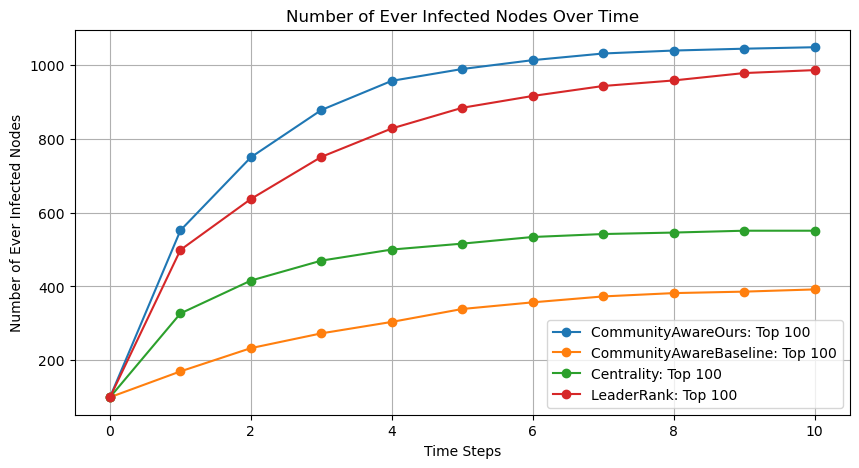

In [47]:

def plot_sir_simulation(G, sorted_maps, top, infection_prob=0.05, steps=100):
    plt.figure(figsize=(10, 5))

    # Calculate average in-degree
    avg_in_degree = sum(dict(G.in_degree()).values()) / G.number_of_nodes()
    print(avg_in_degree)
    recovery_prob = 1 / avg_in_degree

    # Iterate through all sorted maps
    for name, sorted_map in sorted_maps.items():
        top_nodes = [node for node, _ in sorted_map[:top]]  # Extract top nodes
        history, ever_infected, infected_counts = SIR_simulation(G, top_nodes, infection_prob, recovery_prob, steps)
        plt.plot(infected_counts, marker='o', linestyle='-', label=f'{name}: Top {top}')

    plt.title('Number of Ever Infected Nodes Over Time')
    plt.xlabel('Time Steps')
    plt.ylabel('Number of Ever Infected Nodes')
    plt.grid(True)
    plt.legend()
    plt.show()

def SIR_simulation(G, initial_infected, infection_prob=0.1, recovery_prob=0.05, steps=100):
    # Initialize the status of each node
    status = {node: 'S' for node in G.nodes()}
    for node in initial_infected:
        status[node] = 'I'

    history = []
    ever_infected = set(initial_infected)
    infected_counts = [len(ever_infected)]  # Initial number of infected nodes

    # Simulation process
    for _ in range(steps):
        new_status = status.copy()
        for node in G.nodes():
            if status[node] == 'I':
                # Determine neighbors based on whether the graph is directed
                if G.is_directed():
                    # For directed graphs, consider nodes that have edges towards 'node'
                    neighbors = [n for n in G.predecessors(node)]
                else:
                    # For undirected graphs, consider all neighbors
                    neighbors = list(G.neighbors(node))

                # Attempt to infect neighbors
                for neighbor in neighbors:
                    if status[neighbor] == 'S' and random.random() < infection_prob:
                        new_status[neighbor] = 'I'
                        ever_infected.add(neighbor)
                # Recovery process
                if random.random() < recovery_prob:
                    new_status[node] = 'R'
        history.append(new_status)
        status = new_status
        infected_counts.append(len(ever_infected))  # Record the total number of infected nodes

        if not any(s == 'I' for s in status.values()):
            break

    return history, ever_infected, infected_counts



sorted_maps = {
    
     "CommunityAwareOurs": [(node, degree_centrality[node]) for node in ranked_nodes_ours],
    "CommunityAwareBaseline": [(node, degree_centrality[node]) for node in ranked_nodes_baseline],
    "Centrality": sorted_centrality,
    #"indegree_centrality": sorted_indegree_centrality,
    #"PageRank": sorted_pagerank,
    "LeaderRank": sorted_leaderRank,
   # "H-index": sorted_hIndex,
    #"K-Shell": sorted_kShell
}


# 运行模拟并绘图
plot_sir_simulation(G, sorted_maps,top=100, infection_prob=0.1,steps=10)

In [32]:


# 统计前top节点在各社区中的分布
def count_top_nodes_in_communities(G, sorted_maps, top, partition):
    community_counts = {name: {} for name in sorted_maps.keys()}
    
    for name, sorted_map in sorted_maps.items():
        top_nodes = [node for node, _ in sorted_map[:top]]  # 提取前top个节点
        for node in top_nodes:
            community = partition[node]
            if community not in community_counts[name]:
                community_counts[name][community] = 0
            community_counts[name][community] += 1
    
    return community_counts

# 可视化前top节点在各社区中的分布
def plot_top_nodes_distribution(community_counts, top):
    plt.figure(figsize=(15, 10))

    for i, (name, counts) in enumerate(community_counts.items()):
        communities = list(counts.keys())
        counts = list(counts.values())
        
        plt.subplot(3, 3, i + 1)
        plt.bar(communities, counts)
        plt.title(f'Distribution of Top {top} Nodes in Communities\n({name})')
        plt.xlabel('Community')
        plt.ylabel('Number of Top Nodes')

    plt.tight_layout()
    plt.show()

# 统计每个社区的节点数量并排序
def count_and_sort_communities(partition):
    community_counts = {}
    for node, community in partition.items():
        if community not in community_counts:
            community_counts[community] = 0
        community_counts[community] += 1
    
    # 按照节点数量排序社区
    sorted_community_counts = sorted(community_counts.items(), key=lambda x: x[1], reverse=True)
    return sorted_community_counts

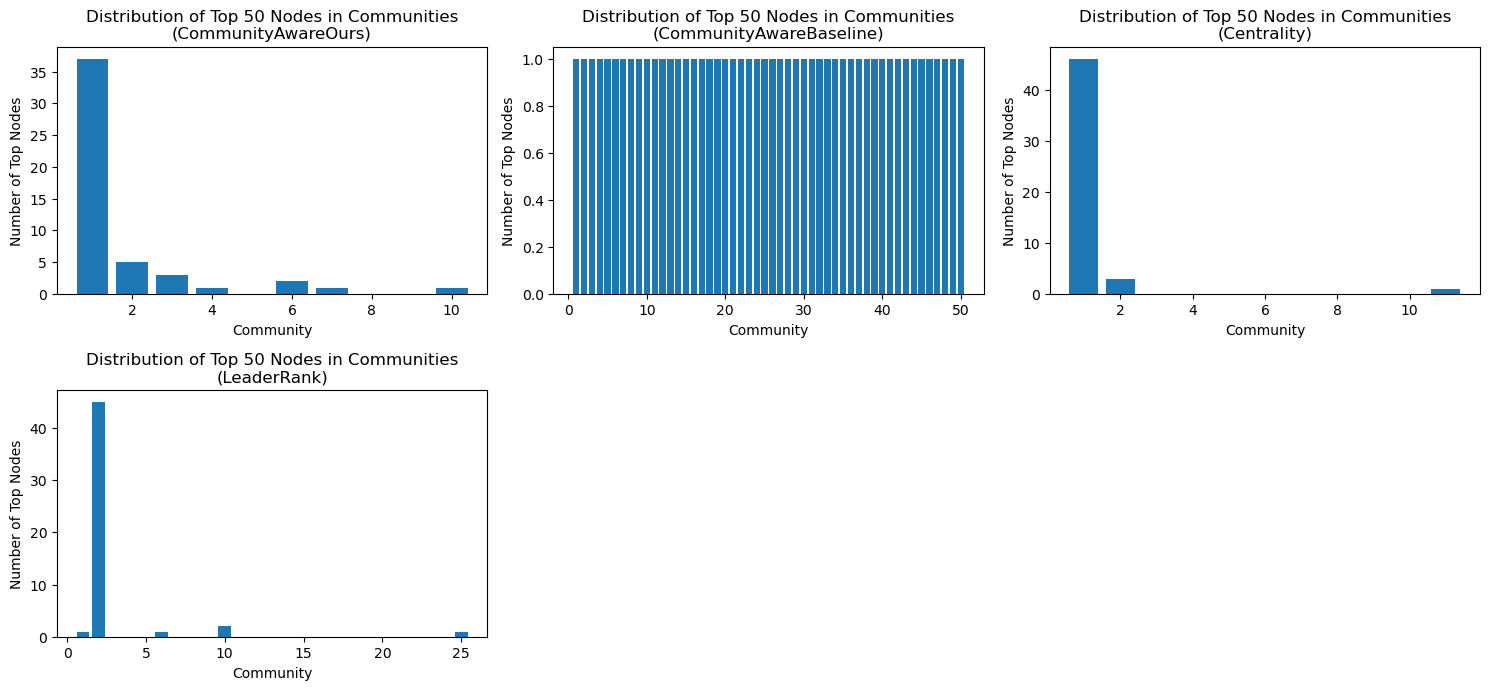

In [ ]:

top = 50

community_counts = count_top_nodes_in_communities(G, sorted_maps, top, partition_infomap)
plot_top_nodes_distribution(community_counts, top)

In [35]:

sorted_community_counts = count_and_sort_communities(partition_infomap)

for community, count in sorted_community_counts:
    print(f"Community {community}: {count} nodes")


Community 1: 295193 nodes
Community 2: 60190 nodes
Community 3: 13863 nodes
Community 4: 7743 nodes
Community 5: 7161 nodes
Community 6: 5882 nodes
Community 8: 4794 nodes
Community 7: 4654 nodes
Community 11: 3582 nodes
Community 9: 3572 nodes
Community 10: 3254 nodes
Community 12: 3205 nodes
Community 13: 2930 nodes
Community 15: 2671 nodes
Community 14: 2665 nodes
Community 18: 2645 nodes
Community 17: 2479 nodes
Community 16: 2409 nodes
Community 20: 2335 nodes
Community 19: 2137 nodes
Community 21: 1846 nodes
Community 24: 1784 nodes
Community 25: 1716 nodes
Community 23: 1581 nodes
Community 22: 1572 nodes
Community 26: 1542 nodes
Community 32: 1526 nodes
Community 27: 1376 nodes
Community 29: 1360 nodes
Community 30: 1329 nodes
Community 28: 1252 nodes
Community 33: 1228 nodes
Community 31: 1202 nodes
Community 34: 1156 nodes
Community 35: 1136 nodes
Community 37: 972 nodes
Community 36: 939 nodes
Community 39: 898 nodes
Community 38: 751 nodes
Community 40: 743 nodes
Community 

In [53]:
def calculate_community_kshell_stats(partition, kshell_scores):
    """
    计算每个社区的k-shell值的均值和总值。

    参数:
    partition: 字典，节点到社区ID的映射。
    kshell_scores: 字典，节点的k-shell得分。

    返回:
    community_stats: 字典，每个社区的k-shell均值和总和。
    """
    # 组织每个社区的节点
    communities = {}
    for node, comm_id in partition.items():
        if comm_id not in communities:
            communities[comm_id] = []
        communities[comm_id].append(node)

    # 计算每个社区的k-shell均值和总和
    community_stats = {}
    for comm_id, nodes in communities.items():
        kshell_values = [kshell_scores[node] for node in nodes]
        mean_kshell = sum(kshell_values) / len(kshell_values) if kshell_values else 0
        total_kshell = sum(kshell_values)
        community_stats[comm_id] = {'mean': mean_kshell, 'total': total_kshell}

    return community_stats

community_stats = calculate_community_kshell_stats(partition_infomap, kShell)

# 打印每个社区的统计数据
for comm_id, stats in community_stats.items():
    print(f"社区 {comm_id} - 均值: {stats['mean']}, 总和: {stats['total']}")


社区 1 - 均值: 1.9944307622470723, 总和: 588742
社区 2 - 均值: 1.7701611563382622, 总和: 106546
社区 3 - 均值: 1.3428550818726106, 总和: 18616
社区 4 - 均值: 1.3693658788583236, 总和: 10603
社区 5 - 均值: 1.3944979751431363, 总和: 9986
社区 6 - 均值: 1.4967698061883714, 总和: 8804
社区 7 - 均值: 1.4860335195530727, 总和: 6916
社区 8 - 均值: 1.3316645807259073, 总和: 6384
社区 9 - 均值: 1.4997200447928332, 总和: 5357
社区 10 - 均值: 1.503380454824831, 总和: 4892
社区 11 - 均值: 1.3570630932439978, 总和: 4861
社区 12 - 均值: 1.4043681747269892, 总和: 4501
社区 13 - 均值: 1.4262798634812286, 总和: 4179
社区 14 - 均值: 1.3223264540337711, 总和: 3524
社区 15 - 均值: 1.3451890677648821, 总和: 3593
社区 16 - 均值: 1.3669572436695725, 总和: 3293
社区 17 - 均值: 1.2496974586526826, 总和: 3098
社区 18 - 均值: 1.1402646502835538, 总和: 3016
社区 19 - 均值: 1.301824988301357, 总和: 2782
社区 20 - 均值: 1.2059957173447537, 总和: 2816
社区 21 - 均值: 1.4723726977248104, 总和: 2718
社区 22 - 均值: 1.4300254452926209, 总和: 2248
社区 23 - 均值: 1.473750790638836, 总和: 2330
社区 24 - 均值: 1.2690582959641257, 总和: 2264
社区 25 - 均值: 1.32226107